# Clustering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import sklearn.cluster as cluster # all clustering techniques except hdbscan
from scipy.spatial import distance 
from scipy.cluster.hierarchy import dendrogram, linkage
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

We will have two toy datasets to try the different methods:

There are a lot of clustering algorithms to choose from the `sklearn` library. So what clustering algorithms should you be using? It depends.

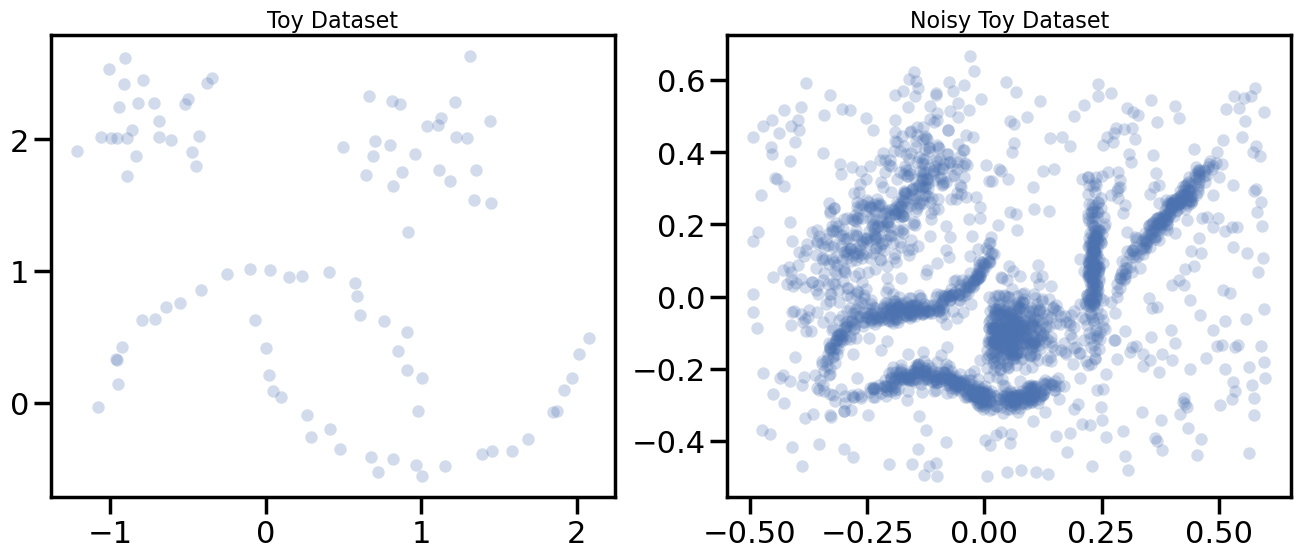

In [2]:
import sklearn.datasets as data

random_state = 41
moons, _ = data.make_moons(n_samples=50, noise=0.05, random_state=random_state)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25, random_state=random_state)
test_data_0 = np.vstack([moons, blobs])

test_data_1 = np.load('clusterable_data.npy')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c='b', **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], color='b', **plot_kwds)
ax[1].set_title('Noisy Toy Dataset', size=16)

plt.show();

## K-means

K-Means is the 'go-to' clustering algorithm for many simply because it is fast, easy to understand, and available everywhere (there's an implementation in almost any statistical or machine learning tool you care to use). However, K-Means has a few problems caused by its simplicity. 

We try the `sklearn` implementation in our toy datasets:

## Aglomerative Single Linkage clustering

c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


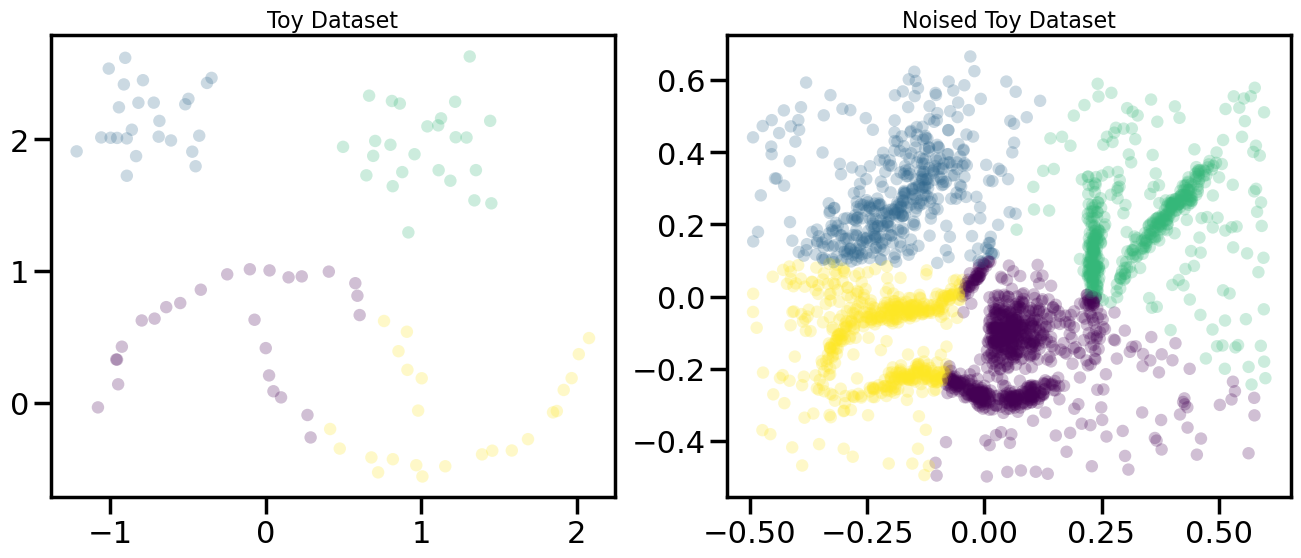

In [3]:
from sklearn.cluster import KMeans
kmeans_0 = KMeans(n_clusters=4, max_iter=200).fit(test_data_0)
kmeans_1 = KMeans(n_clusters=4, max_iter=200).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=kmeans_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=kmeans_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

> - Pour les deux clusters en arc de cercle, K-means n'est pas très efficace du fait de son fonctionnement qui repose sur le calcul de centroïdes
> - La solution dépend de l'initialisation
> - Il faut connaître K à l'avance
> - Non robust aux outliers
> - Echoue pour le cluster de formes non convexes

Agglomerative clustering is a suite of algorithms all based on the same idea. The fundamental idea is that you start with each point in it's own cluster and then, for each cluster, use some criterion to choose another cluster to merge with. Do this repeatedly until you have only one cluster and you get get a hierarchy, or binary tree, of clusters branching down to the last layer which has a leaf for each point in the dataset. The most basic version of this, single linkage, chooses the closest cluster to merge, and hence the tree can be ranked by distance as to when clusters merged/split.

**Code your own Aglomerative Single Linkage clustering algorithm**!:

- Fill in the class 
- During the process, keep track of the cluster merges by saving a (num_samples-1,4) np.array being a linkage matrix in scypy format (to use their function to plot dendrogram: `scipy.cluster.hierarchy.dendrogram`). check documentation.

In [4]:
def find_key(dico, val):
    """Trouve la clé du dictionnaire pour laquelle val appartient à la liste associée si val n'est pas une clé, sinon renvoie val
    """
    if val in dico.keys():
        return val
    else:
        for key in dico.keys():
            if val in dico[key]:
                return key

In [5]:
class my_SingleLinkageAglomerativeClustering():
    
    def __init__(self, metric="euclidean", n_clusters=3):
        '''
        Attributes:
        
        metric_: {"euclidean","precomputed"}
            the distance to be used
            if precomputed then X is distance matrix
        n_clusters: integer
            number of clusters to return 
        linkage_matrix_: (n-1, 4) np.array
            in the same format as linkage  
        labels_: integer np.array
            label assigment
        hierarchy_: list of np.array
            each array corresponds to label assigment
            at each level (number of clusters)
            hierarchy_[0]=np.array(list(range(n)))
        '''
        self.metric_ = metric
        self.n_clusters_ = n_clusters
        self.linkage_matrix_ = None
        self.labels_ = None
        self.hierarchy_ = None
        
    def fit(self, X):
        """ Create a hierarchy of clusters
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self: my_SingleLinkageAglomerativeClustering
            to have access to labels_
        """
        # if it's not precomputed compute the distance matrix
        # using from scipy.spatial import distance 
        n = X.shape[0]
        if self.metric_ == "precomputed":
            dist_matrix = X
        else:
            dist_matrix = distance.squareform(distance.pdist(X, metric=self.metric_))
        
        np.fill_diagonal(dist_matrix, np.inf) # fill diagonal with inf to avoid self-merge

        clusters = {i : [i] for i in range(n)} # Dictionnary mpping the clusters, updated at each iteration
        self.hierarchy_ = [np.arange(n)] # keep track of the hierarchy of clusters

        self.linkage_matrix_ = np.zeros((n-1, 4)) # initialize the linkage matrix

        for k in tqdm(range(n-1)):
            i, j = np.unravel_index(np.argmin(dist_matrix), dist_matrix.shape)
            dist = dist_matrix[i, j]  # We find the closest points

            i_cluster = find_key(clusters, i) # We find the clusters to which the points belong
            j_cluster = find_key(clusters, j) # We find the clusters to which the points belong
            new_cluster = clusters[i_cluster] + clusters[j_cluster] # We merge the clusters


            # Update the linkage matrix
            self.linkage_matrix_[k, 0] = min(i_cluster , j_cluster)
            self.linkage_matrix_[k, 1] = max(i_cluster , j_cluster)
            self.linkage_matrix_[k, 2] = dist
            self.linkage_matrix_[k, 3] = len(new_cluster)
            
            # Update the clusters
            del clusters[i_cluster]
            del clusters[j_cluster]
            clusters[n+k] = new_cluster
            
            # Update the hierarchy
            new_hierarchy = self.hierarchy_[k].copy()
            for key in clusters.keys():
                liste_points = clusters[key]
                for point in liste_points:
                    new_hierarchy[point] = key

            self.hierarchy_.append(new_hierarchy)

            # Modify the distance matrix
            # We set the distance to infinity for all the points in the new cluster, because we don't want to merge them again
            for i in new_cluster:
                for j in new_cluster:
                    dist_matrix[i, j] = np.inf
                    dist_matrix[j, i] = np.inf
            
        
        # We search for the hierarchy list that have the number of clusters we want
        for hierarchy_list in self.hierarchy_:
            if len(np.unique(hierarchy_list)) == self.n_clusters_:
                self.labels_ = hierarchy_list
                break      
        
    def plot_dendrogram(self):
        '''Use self.linkage_matrix_ in `scipy.cluster.hierarchy.dendrogram` 
        to plot the dendrogram of the hierarchical structure
        '''   
        dendrogram(self.linkage_matrix_)
        plt.show()

Apply the method to our toy datasets

100%|██████████| 99/99 [00:00<00:00, 5723.37it/s]

Text(0.5, 1.0, 'Toy Dataset')

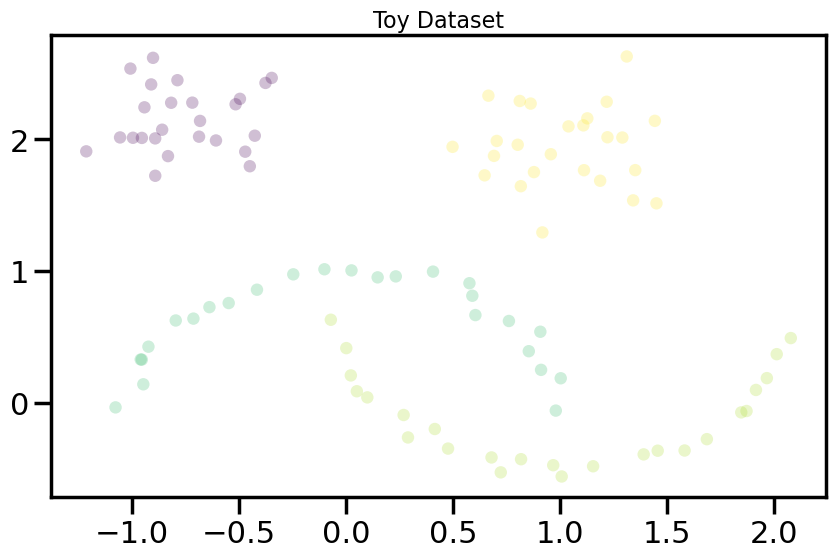

In [6]:
# Our coded model
agglo_method = my_SingleLinkageAglomerativeClustering(n_clusters=4)
agglo_method.fit(test_data_0)

figsize=(10, 6)
plt.figure(figsize=figsize)
plt.scatter(test_data_0.T[0], test_data_0.T[1], c=agglo_method.labels_ , **plot_kwds)
plt.title('Toy Dataset', size=16)

Our implemented model


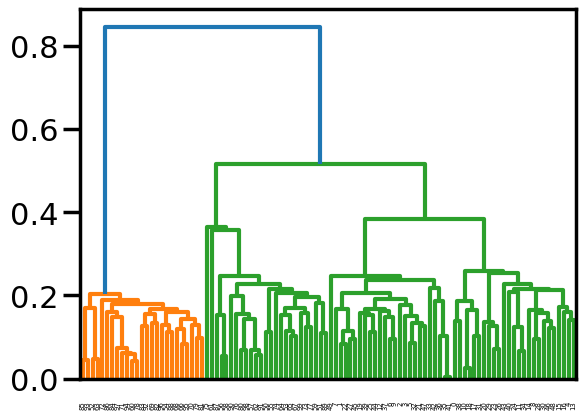

----------
----------
Scipy model


{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [10.0, 10.0, 30.0, 30.0],
  [105.0, 105.0, 115.0, 115.0],
  [95.0, 95.0, 110.0, 110.0],
  [85.0, 85.0, 102.5, 102.5],
  [75.0, 75.0, 93.75, 93.75],
  [65.0, 65.0, 84.375, 84.375],
  [55.0, 55.0, 74.6875, 74.6875],
  [125.0, 125.0, 135.0, 135.0],
  [145.0, 145.0, 155.0, 155.0],
  [130.0, 130.0, 150.0, 150.0],
  [175.0, 175.0, 185.0, 185.0],
  [165.0, 165.0, 180.0, 180.0],
  [205.0, 205.0, 215.0, 215.0],
  [195.0, 195.0, 210.0, 210.0],
  [235.0, 235.0, 245.0, 245.0],
  [225.0, 225.0, 240.0, 240.0],
  [202.5, 202.5, 232.5, 232.5],
  [172.5, 172.5, 217.5, 217.5],
  [140.0, 140.0, 195.0, 195.0],
  [64.84375, 64.84375, 167.5, 167.5],
  [45.0, 45.0, 116.171875, 116.171875],
  [20.0, 20.0, 80.5859375, 80.5859375],
  [285.0, 285.0, 295.0, 295.0],
  [275.0, 275.0, 290.0, 290.0],
  [325.0, 325.0, 335.0, 335.0],
  [355.0, 355.0, 365.0, 365.0],
  [345.0, 345.0, 360.0, 360.0],
  [330.0, 330.0, 352.5, 352.5],
  [315.0, 315.0, 341.25, 3

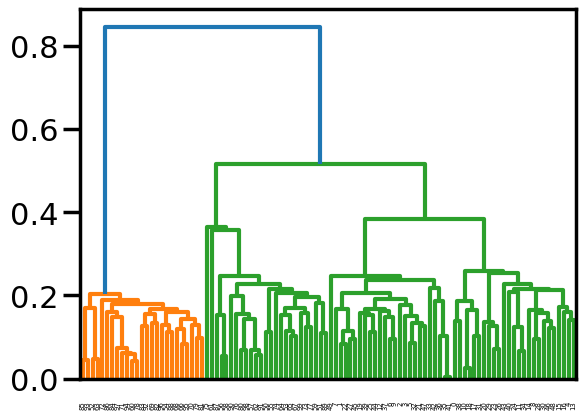

In [7]:
# Verification with scipy
print("Our implemented model")
agglo_method.plot_dendrogram()

print("----------")
print("----------")

print("Scipy model")
Z = linkage(test_data_0, method='single')
dendrogram(Z)

Try the different linkage methods implemented in `sklearn`  and comment

In [8]:
def labels_linkage_method(data, methode='ward'):
    """Test the different linkage methods

    Args:
        methode (str, optional): {‘ward’, ‘complete’, ‘average’, ‘single’}. Defaults to 'ward'.
    """
    agglo_method = cluster.AgglomerativeClustering(n_clusters=4,
                                                   linkage=methode)
    agglo_method.fit(data)
    return agglo_method.labels_

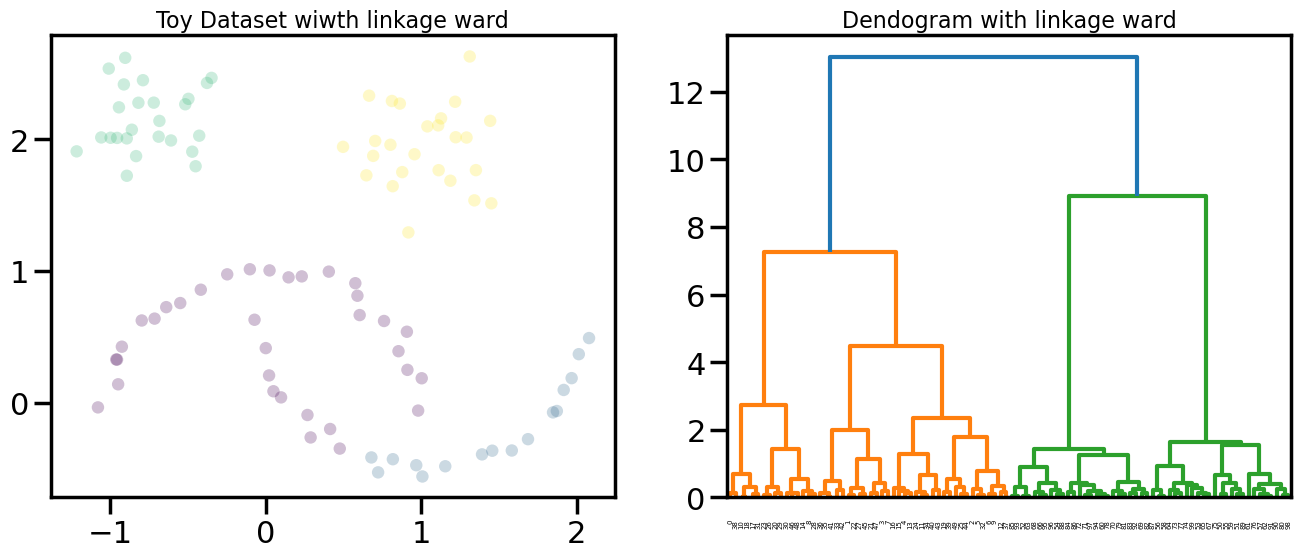

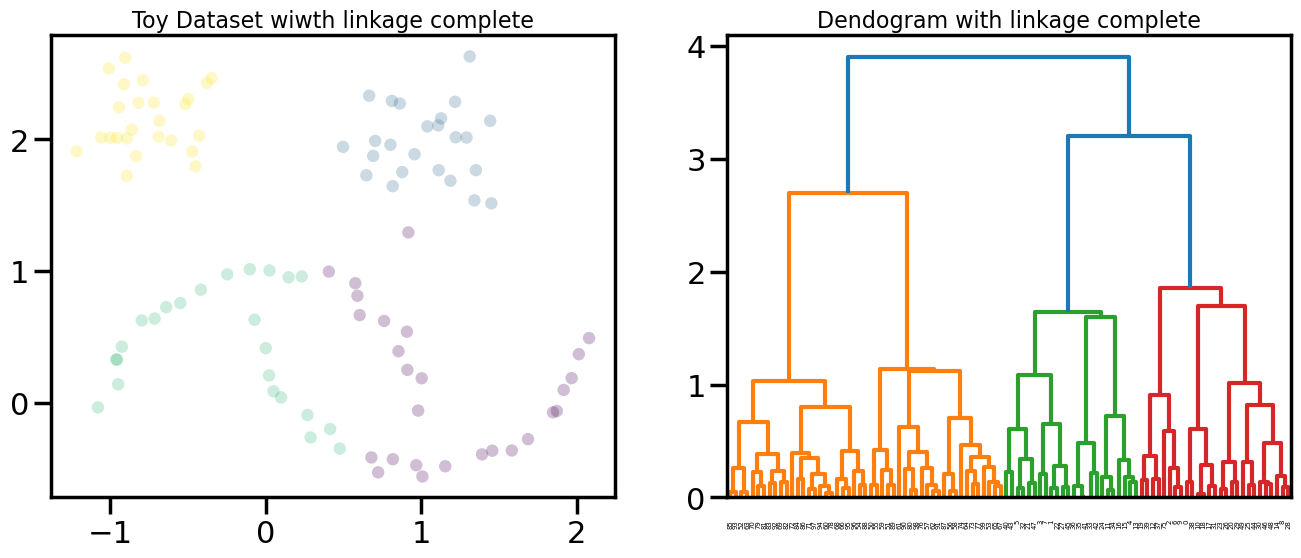

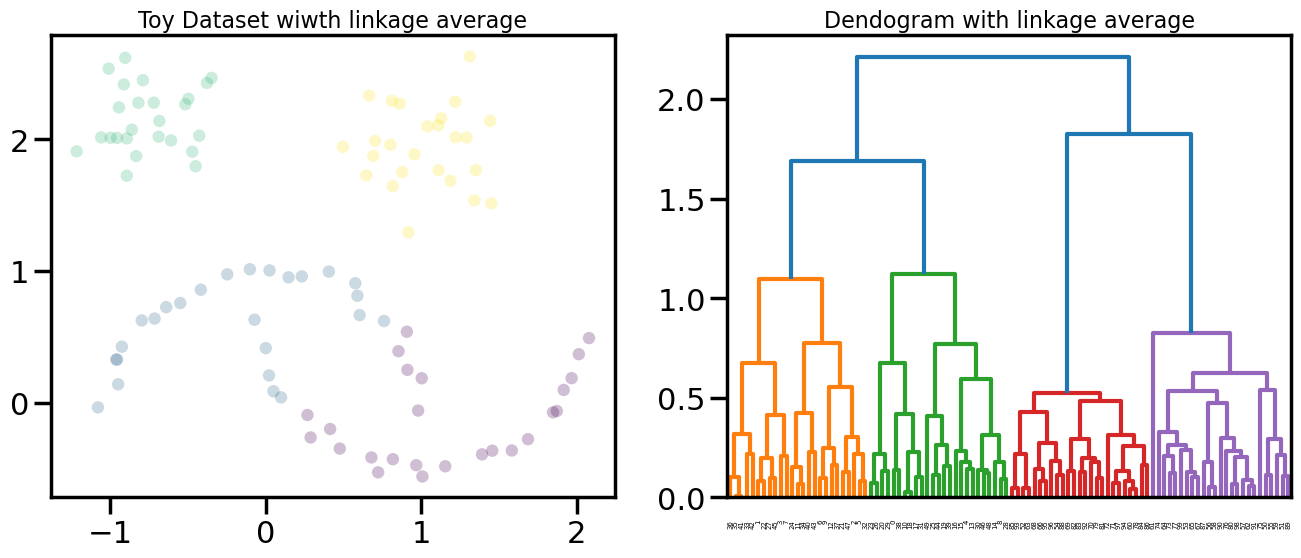

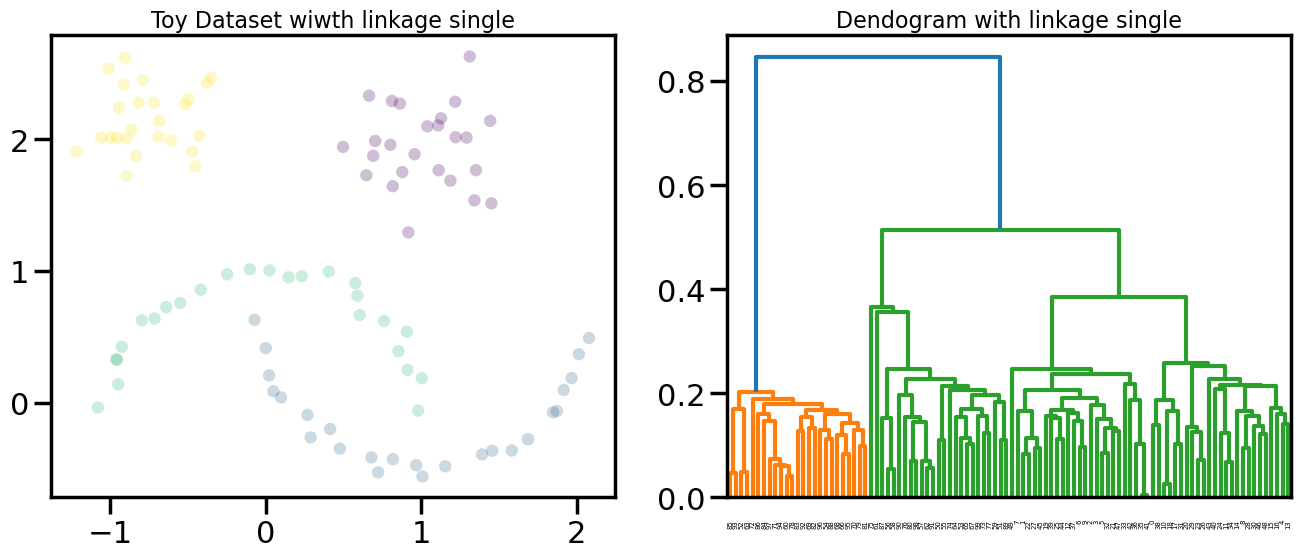

In [9]:
methods = ['ward', 'complete', 'average', 'single']
for method in methods:
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # Cloud points
    labels = labels_linkage_method(test_data_0, methode=method)
    ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=labels , **plot_kwds)
    ax[0].set_title(f'Toy Dataset wiwth linkage {method}', size=16)

    # Dendogram
    Z = linkage(test_data_0, method=method)
    dendrogram(linkage(test_data_0, method=method), ax=ax[1])
    ax[1].set_title(f'Dendogram with linkage {method}', size=16)

> Toutes les méthodes identifient de la même façon les deux clusters du haut, même si le linkage complet semble mal identifier un point qui se situe à mi chemin de deux clusters possibles

> Par contre pour les deux clutsers en forme d'arc les méthodes donnent des résultats différents : on constate bien que la distance choisie a un fort impact sur la forme des clusters finaux

## DBSCAN

DBSCAN is a density based algorithm -- it assumes clusters for dense regions. It is also the first actual clustering algorithm we've looked at: it doesn't require that every point be assigned to a cluster and hence doesn't partition the data, but instead extracts the 'dense' clusters and leaves sparse background classified as 'noise'. In practice DBSCAN is related to agglomerative clustering. As a first step DBSCAN transforms the space according to the density of the data: points in dense regions are left alone, while points in sparse regions are moved further away. Applying single linkage clustering to the transformed space results in a dendrogram, which we cut according to a distance parameter (called epsilon or `eps` in many implementations) to get clusters. Importantly any singleton clusters at that cut level are deemed to be 'noise' and left unclustered. 

Apply it to the test_data, how do you tune the parameters?

Text(0.5, 1.0, 'Toy Dataset')

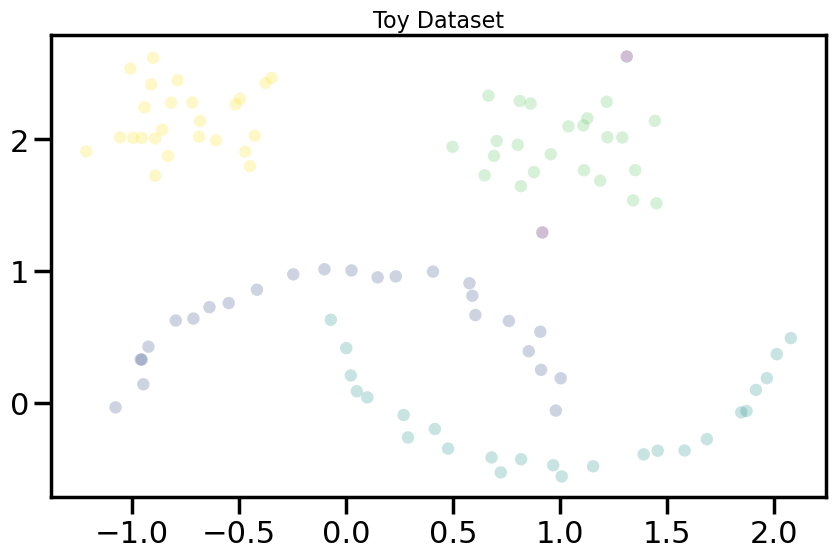

In [10]:
# TODO
dbscan = cluster.DBSCAN(eps=0.3, min_samples=3)
dbscan.fit(test_data_0)
figsize=(10, 6)
plt.figure(figsize=figsize)
plt.scatter(test_data_0.T[0], test_data_0.T[1], c=dbscan.labels_ , **plot_kwds)
plt.title('Toy Dataset', size=16)

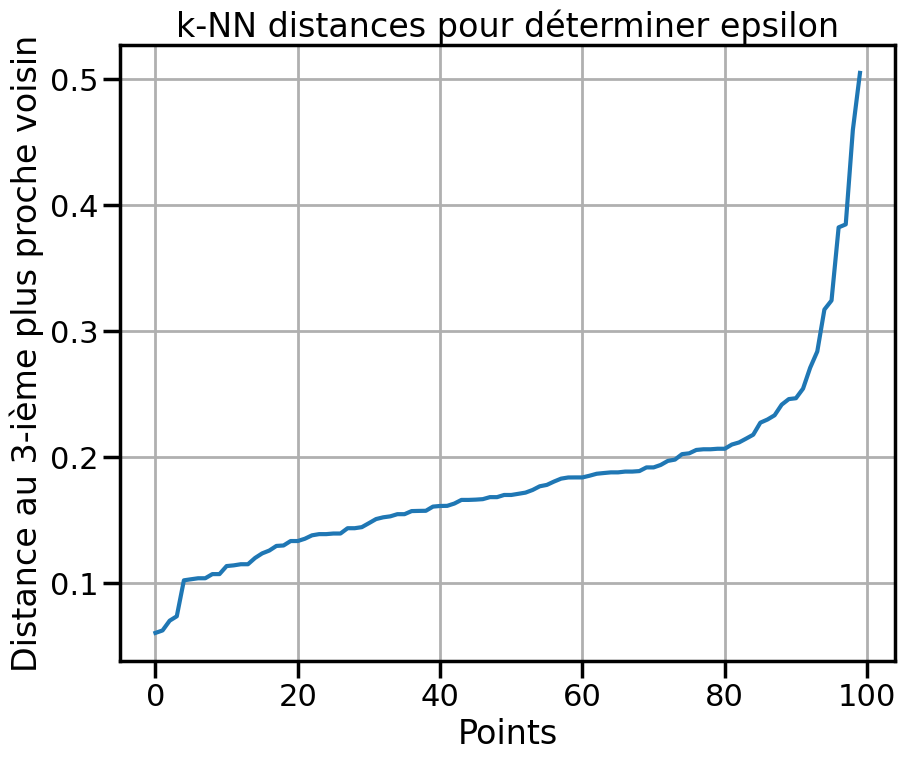

In [11]:
# Choisir le nombre de voisins (MinPts dans le cas de DBSCAN)
k = 3  # Généralement on utilise k = MinPts

from sklearn.neighbors import NearestNeighbors
# Calculer les distances pour les k-plus proches voisins
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(test_data_0)
distances, indices = neighbors_fit.kneighbors(test_data_0)

# Trier les distances des k-plus proches voisins (on prend le k-ième voisin, donc distances[:, k-1])
distances = np.sort(distances[:, k-1])

# Tracer le graphe des distances
plt.figure(figsize=(10, 8))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel(f"Distance au {k}-ième plus proche voisin")
plt.title("k-NN distances pour déterminer epsilon")
plt.grid(True)
plt.show()


> Le choix des paramètres est toujours difficile : il faut trouver epsilon suffisament grand pour que les clusters se forme, mais suffisament petit pour ne pas mélanger différents clusters (au risque de considérer beaucoup de points comme outliers ou bruit). Idem pour min_samples : suffisament élevé pour identifier des régions denses, mais pas trop non plus dans le cas du cluster en forme d'arc de cercle par exemple où l'on voit que le cluster ressemble à une forme d'arc pas très dense

> Dans le cas de ce dataset, un nombre de points min_samples pas trop grand semble adapté, pour former les clusters en forme d'arc de cercle. Idem il ne faut pas epsilon trop petit car les clusters en forme d'arc de cercle ne sont pas très denses

> Après plusieurs tests et aussi à l'aide du "Elbow trick" sur le plot du k-NN (k = min_samples), epsilon = 0.3 et min_samples = 3 semble adapté : bonne forme des clusters, 2 outliers identifiés (points trop isolés des autres)

## HDBSCAN

HDBSCAN is a recent algorithm developed by some of the same people who write the original DBSCAN paper. Their goal was to allow varying density clusters. The algorithm starts off much the same as DBSCAN: we transform the space according to density, exactly as DBSCAN does, and perform single linkage clustering on the transformed space. Instead of taking an epsilon value as a cut level for the dendrogram however, a different approach is taken: the dendrogram is condensed by viewing splits that result in a small number of points splitting off as points 'falling out of a cluster'. This results in a smaller tree with fewer clusters that 'lose points'. That tree can then be used to select the most stable or persistent clusters. This process allows the tree to be cut at varying height, picking our varying density clusters based on cluster stability.

In [12]:
# !pip install hdbscan

In [13]:
import hdbscan

# TODO
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True, min_samples=3)
clusterer.fit(test_data_0)

HDBSCAN(gen_min_span_tree=True, min_samples=3)

<Axes: >

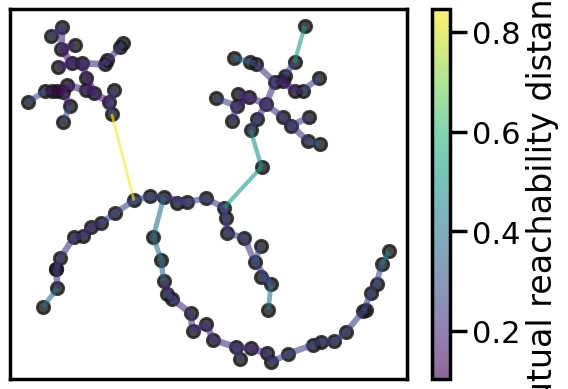

In [14]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

> Montre comment les points sont connectés via des arêtes représentant la plus petite distance possible pour connecter deux points

<Axes: ylabel='distance'>

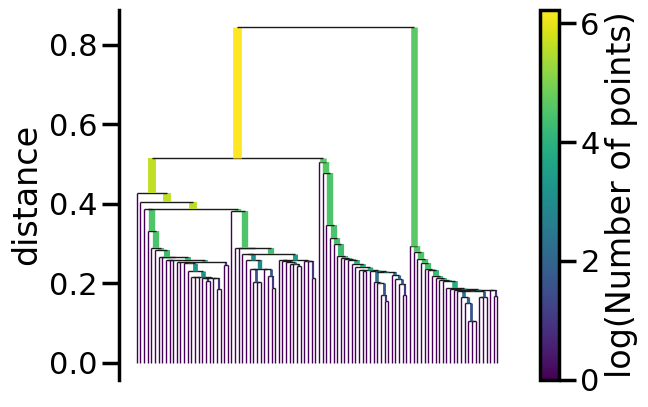

In [15]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

<Axes: ylabel='$\\lambda$ value'>

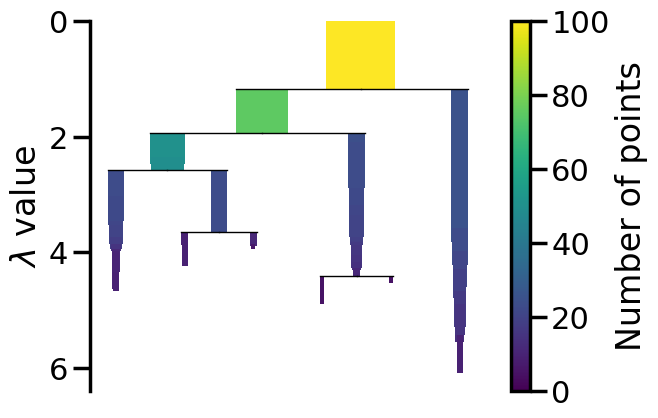

In [16]:
clusterer.condensed_tree_.plot()

<Axes: ylabel='$\\lambda$ value'>

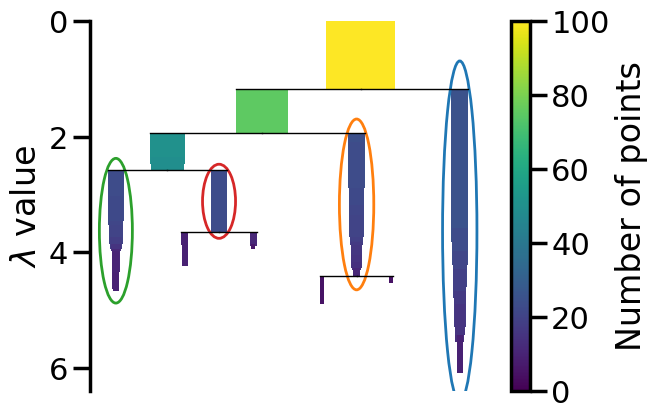

In [17]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

> Sélection des clusters les plus significatifs

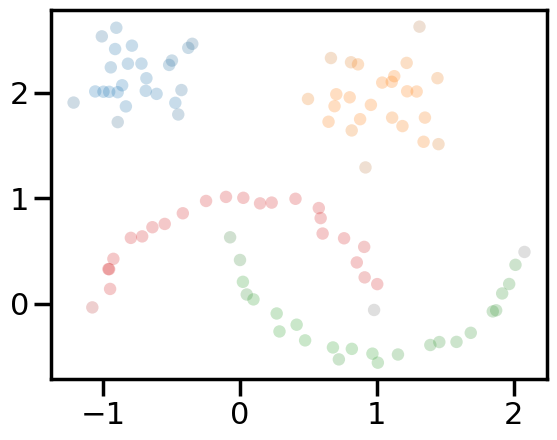

In [18]:
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(test_data_0.T[0], test_data_0.T[1], c=cluster_colors, **plot_kwds)

> HDBSCAN permet :
>- de passer outre le choix de epsilon
>- de scanner toutes les solutions possibles avec toutes les valeurs de epsilon
>- robuste aux outliers et interprétable

## Apply the algorithms to the following images and comment the results

### NASA Curiosity Picture

- Look at following NASA photo taken by a robot in mars:


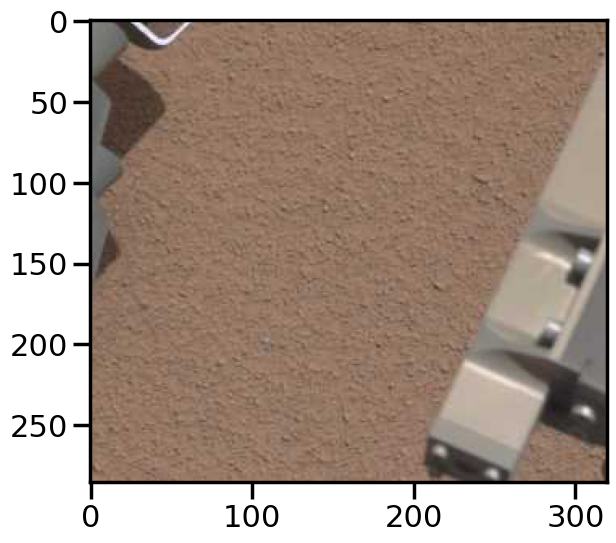

In [19]:
from PIL import Image

Im_1  = Image.open('im_nasa_reduced.jpg')

fig = plt.figure(figsize=(8, 6))
plt.imshow(Im_1)
plt.show()

- Transform the image to an intensity (I) and saturation (S) representation, it helps to distinguish bright and textures.

$$I=\frac{R+G+B}{3}$$
$$S=1-I\times min(R, G, B)$$

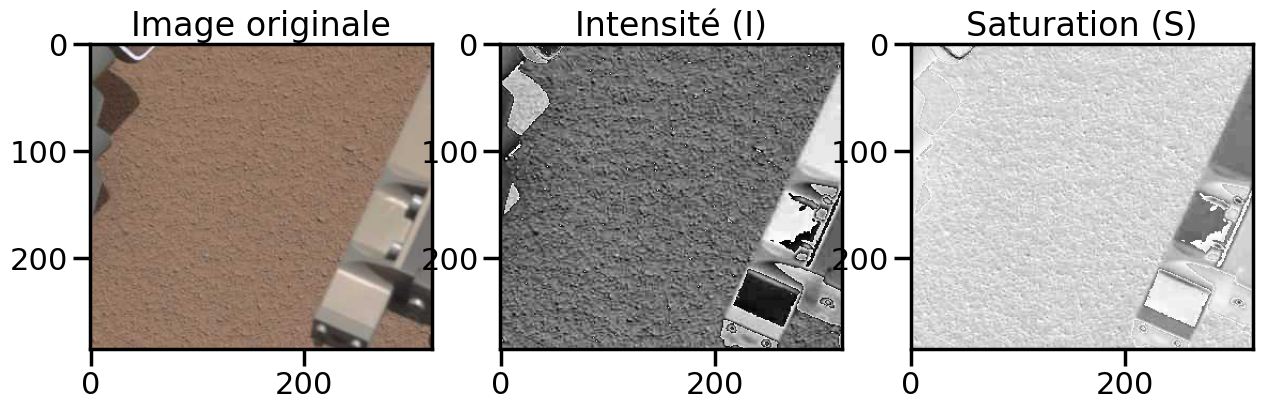

In [20]:
# TODO:
# Convertir en tableau numpy et extraire les canaux R, G, B
Im_1_np = np.array(Im_1)
R, G, B = Im_1_np[:,:,0], Im_1_np[:,:,1], Im_1_np[:,:,2]

# Calculer l'intensité (I)
I = (R + G + B) / 3

# Calculer la saturation (S)
S = 1 - I * np.minimum(np.minimum(R, G), B)

# Préparer les données pour le clustering
data_clustering = np.stack([I.flatten(), S.flatten()], axis=1)  # Fusionner les deux canaux (I et S) en un tableau

# Afficher les résultats
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Image originale
ax[0].imshow(Im_1)
ax[0].set_title("Image originale")

# Afficher l'intensité
ax[1].imshow(I, cmap='gray')
ax[1].set_title("Intensité (I)")

# Afficher la saturation
ax[2].imshow(S, cmap='gray')
ax[2].set_title("Saturation (S)")

plt.show()

- Apply the seen algorithms to segment the image in the Intensity-Saturation representation, comment the results and check if you find something on mars' surface. Be careful with hdbscan and memory errors for some parameters choice (use algorithm='boruvka_kdtree').

#### DBSCAN

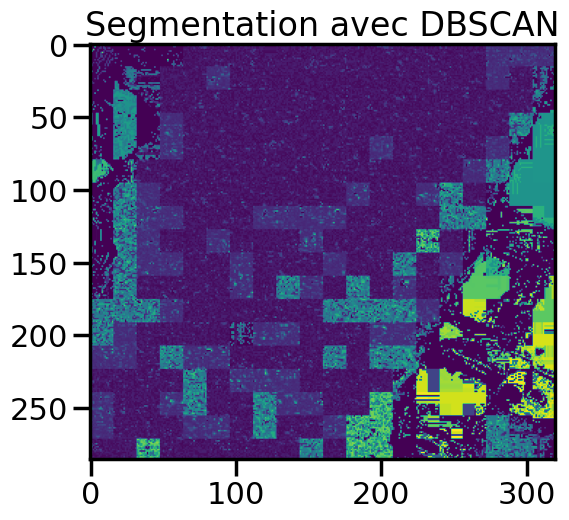

In [21]:
# Appliquer DBSCAN
dbscan = cluster.DBSCAN(eps=1.5, min_samples=15)
labels_dbscan = dbscan.fit_predict(data_clustering)

# Visualiser les résultats de la segmentation
plt.figure(figsize=(6, 6))
plt.imshow(labels_dbscan.reshape(I.shape), cmap='viridis')
plt.title("Segmentation avec DBSCAN")
plt.show()

#### HDBSCAN

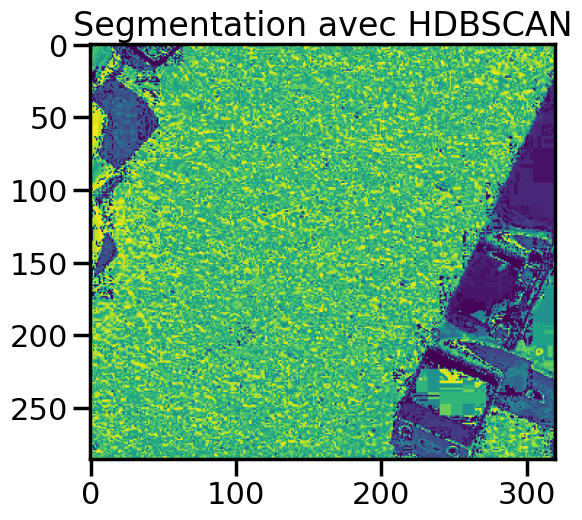

In [22]:
hdbscan_clustering = hdbscan.HDBSCAN(algorithm='boruvka_kdtree', min_cluster_size=10)
labels_hdbscan = hdbscan_clustering.fit_predict(data_clustering)

# Visualiser les résultats de la segmentation
plt.figure(figsize=(6, 6))
plt.imshow(labels_hdbscan.reshape(I.shape), cmap='viridis')
plt.title("Segmentation avec HDBSCAN")
plt.show()

> Le clustering (notamment HDBSCAN) permet de repérer les objets qu'on voie aux bords de l'image

### Color compression

One interesting application of clustering is in color compression within images. 
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

Get a simplified 10-colored version of the following image by applying k-means. Plot both images.

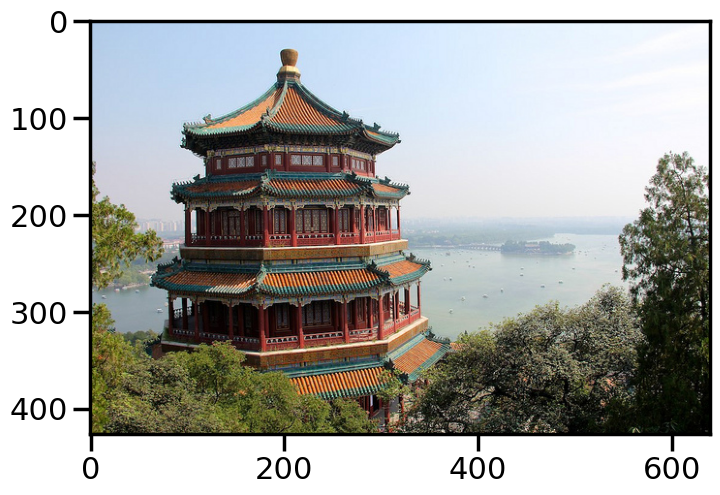

In [23]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")

fig = plt.figure(figsize=(8, 6))
plt.imshow(china);

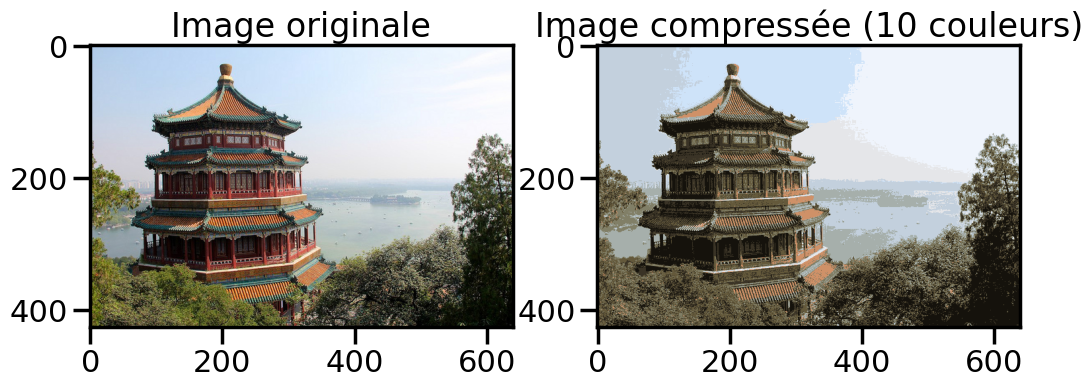

In [24]:
china_np = np.array(china, dtype=np.float64) / 255
width, height, depth = china_np.shape
image_array = np.reshape(china_np, (width * height, depth))

n_colors = 10

# Appliquer K-Means pour trouver 10 clusters de couleurs
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array)
labels = kmeans.predict(image_array)

# Remplacer chaque pixel par la couleur moyenne du cluster correspondant
compressed_image = kmeans.cluster_centers_[labels].reshape(width, height, depth)

# Affichage des images originales et compressées
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(china)
ax[0].set_title("Image originale")

ax[1].imshow(compressed_image)
ax[1].set_title("Image compressée (10 couleurs)")

plt.show()

> On obtient une image compressée donc l'information est tout de même très bien conservée : l'image compressée est lisible et reconnaissable